# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [8]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int) # function that reads data from a txt file and stores it in an array, data is loaded as integers
print(X.shape) # numbers of rows and columns
df = pd.read_csv("data.csv",nrows=5000) # loads 5000 rows of data into a panda dataframe

(5000, 400)


In [9]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape # 5000 labels corresponding to the data.csv rows respectivily

(5000,)

Afficher aléatoirement quelques données de notre base

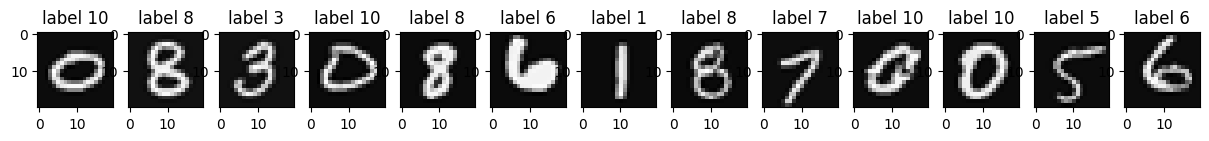

In [10]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

##### Global Matrix for all classes
10 X 10 matrix where : \
row : true class \
column : predicted class \
diagonal elements represent the correct predictions \
off diagnoal elements represent misclassifications

In [14]:
def compute_confusion_matrix(y_true, y_pred, num_classes):
    """
    Compute the confusion matrix from scratch.

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels
        num_classes (int): Number of classes.

    Returns:
        confusion_matrix (array): Confusion matrix of shape [num_classes, num_classes].
        the 10th row of the matrix represents the class 10 (digit 0)
    """
    # Initialize the confusion matrix with zeros
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # Iterate through the true and predicted labels
    for true_label, pred_label in zip(y_true, y_pred):
        # Adjust labels to be 0-based (0-based indexing)
        true_label_idx = true_label - 1  # Convert 1-10 to 0-9
        pred_label_idx = pred_label - 1  # Convert 1-10 to 0-9
        
        # Increment the corresponding cell in the confusion matrix
        cm[true_label_idx, pred_label_idx] += 1
    
    return cm      

##### Matrix for each class
we will generate 10 different matrices of 2X2 \
True Positive (TP)  False Negative (FN) \
False Positive (FP) True Negative (TN) 



In [ ]:
def confusion_matrix_per_class(y_true, y_pred, num_classes):
    """
    Compute the confusion matrix for each class (one-vs-all).

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels 
        num_classes (int): Number of classes.

    Returns:
        class_cm (dict): A dictionary where keys are class labels and values are 2x2 confusion matrices.
    """
    class_cm = {}
    
    for class_label in range(1, num_classes + 1): # num_classes +1 = 11 : because in range should go from 1 to 10
        # Create binary labels for the current class : 1 for current class , 0 for other classes
        y_true_binary = (y_true == class_label).astype(int)  # as type converts boolean value true or false to 1 or 0
        y_pred_binary = (y_pred == class_label).astype(int)
        
        # Compute the 2x2 confusion matrix for the current class
        tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))  # True Positives
        tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))  # True Negatives
        fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))  # False Positives
        fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))  # False Negatives
        
        # Store the confusion matrix for the current class
        class_cm[class_label] = np.array([[tn, fp], [fn, tp]])
    
    return class_cm

- Accuracy = (TP + TN)/(TP + TN + FP + FN)

##### Overall accuracy

In [20]:
def overall_accuracy(y_true,y_pred):
  correct_predictions = 0 # initialise counter for correct predictions TP+TN
  for i in range(len(y_true)):
    if(y_true[i]== y_pred[i]):
      correct_predictions +=1
  
  overall_accuracy = correct_predictions / len(y_true) # len(y_true) = TP + TN + FP + FN

##### accuracy for each class

In [18]:
def accuracy_per_class(y_true, y_pred, num_classes):
    """
    Compute accuracy for each class.

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels 
        num_classes (int): Number of classes.

    Returns:
        class_accuracy (dict): A dictionary where keys are class labels and values are accuracies.
    """
    class_accuracy = {}
    
    for class_label in range(1, num_classes + 1):  # Classes are labeled from 1 to num_classes
        # Indices of samples that belong to the current class
        class_indices = (y_true == class_label) # boolean values 0 or 1 for rows of y_true corresponding to the class
        
        # Number of samples for the current class
        total_samples = np.sum(class_indices) # sum of boolean values is going to be number of rows of the class
        
        if total_samples == 0:
            # If there are no samples for this class, set accuracy to 0 or handle it as needed
            class_accuracy[class_label] = 0. # float
            continue
        
        # Number of correct predictions for the current class
        correct_predictions = np.sum((y_true == class_label) & (y_pred == class_label))
        
        # Accuracy for the current class
        accuracy = correct_predictions / total_samples
        class_accuracy[class_label] = accuracy
    
    return class_accuracy

- Recall (True Positive Rate) = TP/(TP + FN)

##### Recall for each class

In [ ]:
def recall_per_class(y_true, y_pred, num_classes):
    """
    Compute recall for each class.

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels 
        num_classes (int): Number of classes.

    Returns:
        class_recall (dict): A dictionary where keys are class labels and values are recall values.
    """
    class_recall = {}
    
    for class_label in range(1, num_classes + 1):  # Classes are labeled from 1 to num_classes
        # True Positives (TP): Correctly predicted as the current class
        tp = np.sum((y_true == class_label) & (y_pred == class_label))
        
        # False Negatives (FN): Belong to the current class but predicted as another class
        fn = np.sum((y_true == class_label) & (y_pred != class_label))
        
        # Avoid division by zero
        if (tp + fn) == 0:
            recall = 0.0  # If there are no samples for this class, set recall to 0
        else:
            # Compute recall
            recall = tp / (tp + fn)
        
        # Store the recall for the current class
        class_recall[class_label] = recall
    
    return class_recall

##### Overall Recall 

In [21]:
def overall_recall(y_true, y_pred, num_classes):
    """
    Compute overall recall.

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels 
        num_classes (int): Number of classes.

    Returns:
        overall_recall (float): Overall recall.
    """
    # Initialize variables to store total TP and FN
    total_tp = 0
    total_fn = 0
    
    # Iterate over each class
    for class_label in range(1, num_classes + 1):
        # True Positives (TP): Correctly predicted as the current class
        tp = np.sum((y_true == class_label) & (y_pred == class_label))
        total_tp += tp
        
        # False Negatives (FN): Belong to the current class but predicted as another class
        fn = np.sum((y_true == class_label) & (y_pred != class_label))
        total_fn += fn
    
    # Compute overall recall
    if (total_tp + total_fn) == 0:
        overall_recall = 0.0  # Avoid division by zero
    else:
        overall_recall = total_tp / (total_tp + total_fn)
    
    return overall_recall

- Précision = TP/(TP + FP)

- Taux de FP (False Positive Rate) = FP / (FP + TN)

- Spécificité (True Negative Rate) = TN / (TN + FP)

- Courbe ROC

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [6]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

# Méthode 1: MVS
Machine à Vecteurs de Support

In [7]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

4


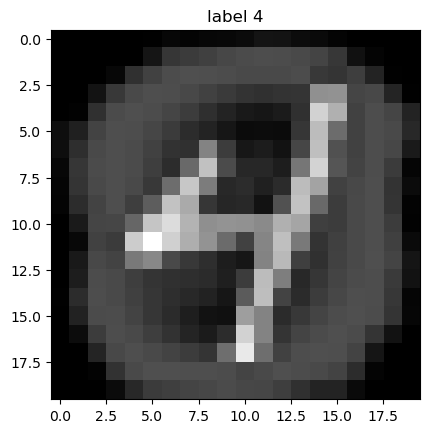

In [9]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


In [10]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

4


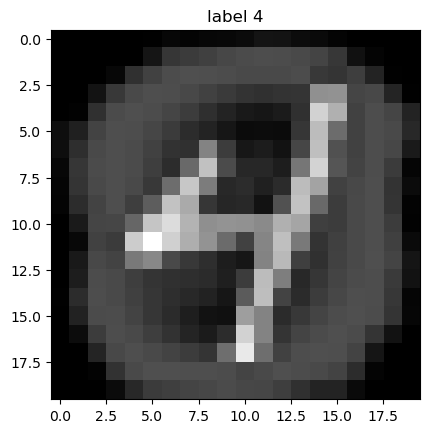

In [12]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [13]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [14]:
# Choisir un image de test 
c=0

In [15]:
model.predict([Xtt[c,:]])

array([6])

In [16]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[0.13231671, 0.1283596 , 0.12373583, 0.02821868, 0.13087072,
        0.13778388, 0.02291431, 0.13170961, 0.03469736, 0.1293933 ]])

Afficher l'image testée

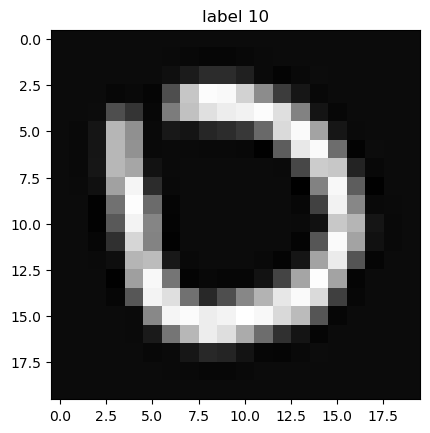

In [17]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

# Appliquer les métriques implementées pour voir le résultat